> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from  filtered EMG data (should be highly unique). Thus, implement a basic ML model to link the EMG data back to the corresponding subject.  

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from kcs_ml_infr import *

from IPython.display import display

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

# Load In Data

In [2]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


Load in the other data
> This cell takes ~2 minutes to run as a heads up

In [3]:
emg_labels_df1 = pd.read_csv("Data\emg_labels1.csv")
emg_labels_df2 = pd.read_csv("Data\emg_labels2.csv")
emg_labels_df = pd.concat((emg_labels_df1, emg_labels_df2))

try:
    emg_labels_df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    # Masterful code here
    print("NO UNNAMED COLUMN DETECTED!")

print(emg_labels_df.shape)
emg_labels_df.head()

(7232, 4)


,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [4]:
labels_df = pd.DataFrame(emg_labels_df['Subject'].map(key_to_num))
labels_df.head()

,Subject
0,0
1,0
2,0
3,0
4,0


# Filtered EMG Data Privacy Evaluation
>Linking EMG Data to Participants
1. Does the channel matter / improve performance? Within the same block (assuming different blocks have the strap re-put on) then presumably the same muscles should act in similar ways.  __Just do PCA on it and don't worry about it__
2. Does the condition matter? Presumably, but the question is how much.  __Only look at condition for conditions that changed performance (eg learning rate speed)__

## Load the Envelopes of Filtered EMG Data

In [12]:
#envelope_df50 = pd.read_csv("Data\envelope_df50.csv")
envelope_df100 = pd.read_csv("Data\envelope_df100.csv")
#envelope_df150 = pd.read_csv("Data\envelope_df150.csv")
#envelope_df200 = pd.read_csv("Data\envelope_df200.csv")
#envelope_df250 = pd.read_csv("Data\envelope_df250.csv")
envelope_df300 = pd.read_csv("Data\envelope_df300.csv")

print("300")
print(envelope_df300.shape)
display(envelope_df300.head())
print()
print("100")
print(envelope_df100.shape)
envelope_df100.head()

300
(7168, 85)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,74,75,76,77,78,79,80,81,82,83
0,0,16.039004,36.325269,43.391848,36.107714,27.174672,49.448270,51.368385,37.940213,52.916814,...,54.848651,32.178651,55.999227,38.673871,36.057432,38.680939,30.602733,42.702725,46.587541,52.493973
1,1,14.812210,38.867724,41.456289,35.945107,21.961607,36.666727,43.116734,36.161965,63.684219,...,57.584892,31.764491,47.537943,40.312659,35.631023,40.138776,29.840938,44.481492,41.404971,71.415014
2,2,16.703434,33.876677,28.719956,32.610202,24.842942,28.846417,39.043875,28.246880,59.862159,...,38.138087,26.336236,30.525449,34.003054,34.920630,30.277660,25.223717,36.384580,26.858568,75.697863
3,3,16.299232,25.305739,24.205310,23.506614,21.627513,21.486329,27.809602,29.349328,45.415651,...,26.750009,23.595760,22.733679,28.767058,30.544744,25.519212,24.399772,31.460005,21.396390,59.006003
4,4,11.059086,16.826146,15.512912,20.724276,14.451597,18.581644,20.162851,28.101514,30.671754,...,18.109695,16.954669,14.681352,19.612310,21.273132,17.865894,16.806739,21.421492,14.739460,38.270479



100
(7168, 209)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,198,199,200,201,202,203,204,205,206,207
0,0,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
1,1,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
2,2,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
3,3,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263
4,4,10.168381,10.501039,12.856129,16.059131,20.128401,13.435236,16.672336,18.134148,20.744904,...,14.751494,19.967234,19.091210,16.293000,20.945203,25.093296,14.147869,10.369884,15.788238,26.206604


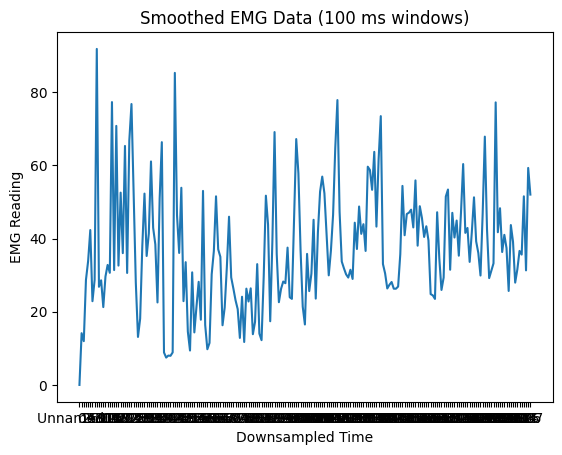

In [12]:
plt.plot(envelope_df100.iloc[0, :])
plt.xlabel("Downsampled Time")
plt.ylabel("EMG Reading")
plt.title("Smoothed EMG Data (100 ms windows)")
plt.show()

# Make ML Model Attack
> Trying without doing any sample reduction just to see if the run times are bearable... if so, then maybe don't need to do any PCA and can save myself the trouble

In [13]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
# Set the number of k-folds
cv = 5
    
# Result logs
my_metrics_cols = ['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
res_df = pd.DataFrame(columns=my_metrics_cols)

my_models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(norm_input_df, norm_label_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

In [ ]:
for model_num, model in enumerate(my_models):
    norm1d_res_df = train_model(model, X_train, y_train, cv, norm1d_res_df)

In [ ]:
norm1d_res_df.head(100)

In [ ]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])

for model_num, model in enumerate(my_models):
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)

In [ ]:
test_df.head(100)

## Investigate How Performance Changes Per Update
> E.g. as we use later intervals (note, not more intervals, just the later ones), does the EMG performance linking improve? Intuitively it should not.

In [ ]:
print(update_ix)
print()

# Scale update_ix to be for the new envelope_df, as it is currently meant for the original dataset
env_update_ix = np.array(np.ceil(update_ix/20770*envelope_df.shape[1]), dtype='int')
print(env_update_ix)

In [ ]:
def nth_emg_model(nth_emg_df, emg_label_df, n, my_models, my_metrics_cols=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds', 'N'], cv=5, test=True):
    ''''''

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(nth_emg_df, emg_label_df)
    y_train = np.ravel(y_train)

    dec_res_df = pd.DataFrame(columns=my_metrics_cols)
    #print("TRAINING")
    for model_num, model in enumerate(my_models):
        #print(f"{model_num} of {len(my_models)}")
        dec_res_df = train_model(model, X_train, y_train, cv, dec_res_df, dec_num=n)
        
    test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
    if test:
        #print("TESTING")
        for model in my_models:
            #print(f"{model_num} of {len(my_models)}")
            test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv, dec_num=n)
            
    return dec_res_df, test_df

This cell also takes forever to run too lol
> ONLY 18 updates because here we have to take full intervals as opposed to just grabbing the value at the update time (19 update indices and thus 18 intervals)

In [ ]:
test_df = pd.DataFrame(columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds', 'N'])
test_df.head()

for i in range(19):
    print(f"{i} of 18")
    if i==18:
        pass
    else:
        current_emg_df = envelope_df.iloc[:, env_update_ix[i]:env_update_ix[i+1]]
        current_dec_res_df, current_test_df = nth_emg_model(current_emg_df, labels_df, i, my_models, test=True)
        test_df = pd.concat((test_df, current_test_df))

In [ ]:
test_df.head(7)

In [ ]:
lr_df = test_df[test_df['Algorithm']=='LogisticRegression()']
knn_df = test_df[test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = test_df[test_df['Algorithm']=='LinearSVC()']
dt_df = test_df[test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = test_df[test_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(list(range(18)), lr_df.iloc[:, 5], label='LogReg')
plt.plot(list(range(18)), knn_df.iloc[:, 5], label='KNN')
plt.plot(list(range(18)), svc_df.iloc[:, 5], label='SVC')
plt.plot(list(range(18)), dt_df.iloc[:, 5], label='DTree')
plt.plot(list(range(18)), gbt_df.iloc[:, 5], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of EMG Update Interval')
plt.legend(loc='best')
plt.show()

Note the massive drop at the last update is because the last update is not the same size as the rest of the updates, it is much smaller and thus the drop in performance.